# Ising model: Monte Carlo simulations#

In [1]:
## if tqdm is not yet installed (error in the next cell): 
## remove comment # below and run this cell to install
#!python -m pip install tqdm

In [2]:
## Python libraries to load
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation

import numpy as np
from tqdm import tqdm
import copy

## 1. Support functions ##
Functions used to generate look-up tables, calculated specific properties and perform single MC steps.

In [3]:
## Generating look-up tables
def get_PBC(L:int)->tuple:
    """
    Create two look-up tables for the +1 and -1 sites, 
    taking periodic boundary conditions into account.
    
    parameters:
        - L : linear dimension of the spin-lattice
    """
    kp=np.zeros(L,dtype=int)
    km=np.zeros(L,dtype=int)
    for i in range(L):
        kp[i]=i+1
        km[i]=i-1
    kp[L-1]=0
    km[0]=L-1
    return kp,km
    
def get_transProb_book(L,B,kT)->np.ndarray:
    """
    Create a look-up table with the possible calculated transition probabilities "w".
    This is the version as presented in the book Stat.Phys. of Casquihlo & Teixeira.
    It assumes the magnetic field "B" to be defined as:   B=µB*B/Jc
    As a result, no coupling constant Jc is explicitly present.
    
    parameters:
        - L : linear dimension of the spin-lattice.
        - B : magnetic field (as defined): B=µB*B/Jc
        - kT: Boltzman factor kB*T/Jc (note the book is missing T, which is corrected here)
    """
    delta=np.zeros((3,9))
    w=np.zeros((3,9))
    for i in [-1,1]:
        for j in [-4,-2,0,2,4]:
            delta[i,j]=j+i*B
    for i in [-1,1]:
        for j in [-4,-2,0,2,4]:
            w[i,j]=1
            if (delta[i,j]>0):
                w[i,j]=np.exp(-2*delta[i,j]/kT)
    return w

def get_transProb(L,Jc,B,kT)->np.ndarray:
    """
    Create a look-up table with the possible calculated transition probabilities "w".
    This is a more intuitive version, which takes both the coupling constant and 
    magnetic field terms explicitly.
    
    parameters:
        - L  : linear dimension of the spin-lattice.
        - Jc : Couping constant between spins (in meV)
        - B  : Magnetic field µB*B (with µB in meV/T and B in T)
        - kT : Thermal factor kB*T (kB in meV/K)
    """
    delta=np.zeros((3,9))
    w=np.zeros((3,9))
    for i in [-1,1]:
        for j in [-4,-2,0,2,4]:
            delta[i,j]=j*Jc+i*B
    for i in [-1,1]:
        for j in [-4,-2,0,2,4]:
            w[i,j]=1
            if (delta[i,j]>0):
                w[i,j]=np.exp(-2*delta[i,j]/kT)
    return w

###################################################################
## grid-functions
def init_sampleFM(L)->np.ndarray:
    """
    Generate a grid in a Ferromagentic configuration.
    parameters:
        - L  : linear dimension of the spin-lattice.
    """
    grid=np.zeros((L,L))
    for i in range(L):
        for j in range(L):
            grid[i,j]=-1
    return grid

def init_sampleRand(L)->np.ndarray:
    """
    Generate a grid in a (uniform) random noise configuration
    parameters:
        - L  : linear dimension of the spin-lattice.
    """
    grid=np.random.randint(low=0,high=2,size=(L,L))
    grid[:,:]=(((grid[:,:]*1.0)-0.5)*2.0)
    return grid


## MC functions
def do_mcs_step_BookSweep(g,L,iplus,imin,w):
    """
    Perform a single Monte-Carlo sweep of the grid following the approach 
    presented in the book. This approach just runs over all sites in an 
    ordered fashion and decides for each site to flip or not. As everything
    happen in-grid this can have significant effect of correlating the update
    rounds as a site i+1 will be updated taking into account the update of the
    site i. As such, this approach should not be used as updates of sites are
    correlated. (conceptually) Better approaches are given below.
    
    parameters:
        - g : 2D spin lattice
        - L : linear dimension of the spin-lattice.
        - iplus, imin : pregenerated look-up tables for the +1 and -1 sites.
        - w : look-up table with transition probabilities.
    """
    #generate all possibly required random numbers in one go (less overhead)
    rn=np.random.rand(L*L) #uniform over 0..1
    for i in range(L):
        for j in range(L):#loop over grid in ordered fashion
            site=g[i,j]
            som=g[iplus[i],j]+g[imin[i],j]+g[i,iplus[j]]+g[i,imin[j]]
            k1=int(site*som)
            k2=int(site)
            r=rn[i*L+j]
            if (r<w[k2,k1]):#flip or not?
                g[i,j]=-site

def do_mcs_step_RandSweep(g,L,iplus,imin,w):
    """
    Perform a single Monte-Carlo "sweep of the grid". In this algorithm we do not run 
    in an ordered fashion over all grid-points but randomly select L² grid points
    to update in sequence. This update-rule should be seen as a sequence of L²
    site updates, presenting a more realistic way of updating the system. In this 
    approach it is also not certain every site will be selected on each run, some 
    other sites on the other hand may be selected more than once.
    Similar as the in book version, the updates are performed "ingrid" requiring less
    storage, and making the atomic events a timeseries. As such the "later" updates are
    influenced by the previous ones, but in a more natural way than before.
    
    parameters:
        - g : 2D spin lattice
        - L : linear dimension of the spin-lattice.
        - iplus, imin : pregenerated look-up tables for the +1 and -1 sites.
        - w : look-up table with transition probabilities.
    """
    #generate all possibly required random numbers in one go (less overhead)
    rn=np.random.rand(L*L) #uniform over 0..1
    sites=np.random.randint(low=0,high=L,size=(L*L,2))
    for k in range(L*L):
        i=sites[k,0]
        j=sites[k,1]
        site=g[i,j]
        som=g[iplus[i],j]+g[imin[i],j]+g[i,iplus[j]]+g[i,imin[j]]
        k1=int(site*som)
        k2=int(site)
        r=rn[i*L+j]
        if (r<w[k2,k1]):#flip
            g[i,j]=-site

## Collect/calculate properties
def calc_TotM(g: np.ndarray)-> float:
    """ 
    Calculate the total magnetic moment of the 2D Ising model
    parameters:
        - g  : 2D grid of lattice sites   
    """
    return np.mean(g)

def calc_TotE(g: np.ndarray,L, B, J,iplus,imin)-> float:
    """ 
    Calculate the total energy of the 2D Ising model using global J & B
    parameters:
        - g  : 2D grid of lattice sites
    """
    TE = 0.0
    for i in range(L):
        for j in range(L):
            TE -= B*g[i,j]   # contribution due to the interaction with the magnetic field
            som=g[iplus[i],j]+g[imin[i],j]+g[i,iplus[j]]+g[i,imin[j]]
            TE -= 0.5*J*(g[i,j]*som) # contribution due to the spin-coupling, 
                                     # *0.5 because halve bonds to prevent double counting
    return TE/(L*L) #return the average site energy


## 2. 2D Ising model ##
Some global parameters for the Ising model.
### 2.1. Simulation ###

In [4]:
J      = 1.0          # The coupling constant in energy "meV" (1k_BT = 26meV@RT)
Bfield = 0.0          # The magnetic field in Tesla
muB    = 5.788381e-2  # Bohrmagneton in meV/Tesla
Bf     = Bfield*muB   # Practical magnetic field factor in meV
T      = 26.0         # Temperature in Kelvin
kBT    = T*8.617333e-2# k_B in meV/K

latdim = 10           # Lateral lattice dimension
N      = latdim**2    # Total number of lattice sites in a 2D lattice

In [5]:
## The main loop
mcsmax  = 10000 # Number of lattice sweeps to perform
Ninit   = 2     # Number of sweeps used as initialisation of the system
Nsample = 2     # System properties are collected every # systems-sweeps

## Properties we will be tracking
propE = list() # The total energy of the system
propM = list() # The total magnetisation of the system
avgE  = list() # Running averages...
avgM  = list()
cntp  = 0      # Counter of property-indices

## Look-up tables
kp, km = get_PBC(latdim)
w = get_transProb(latdim,J,Bf,kBT)
## Initialisation
grid = init_sampleFM(latdim)
#grid = init_sampleRand(latdim)
#Monte Carlo run
cnt=0
x=list()
bar = tqdm(total=mcsmax)
bar.update(Ninit)
for mcs in range(mcsmax):
    do_mcs_step_BookSweep(grid,latdim,kp,km,w)# do a single update-round
    #do_mcs_step_RandSweep(grid,latdim,kp,km,w)# do a single update-round
    if mcs > Ninit:
        cnt += 1
        if cnt >= Nsample:
            propE.append(calc_TotE(grid,latdim,Bf,J,kp,km))
            propM.append(calc_TotM(grid))
            avgE.append(np.mean(propE))
            avgM.append(np.mean(propM))
            x.append(mcs)
            cntp += 1
            cnt   = 0
            bar.update(Nsample)
bar.close()
#Nconf = cntp

100%|██████████████████████████████████████████████████████████████████████████▉| 9998/10000 [00:04<00:00, 2137.37it/s]


### 2.2. Plot the results ###

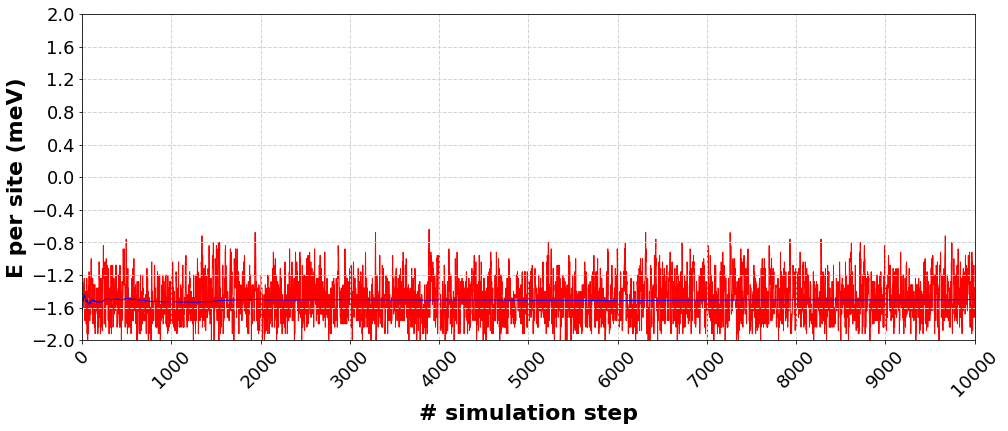

In [6]:
## The energy
%matplotlib inline 
plt.figure(figsize=(16,6))

plt.plot(x, propE, color="red"   ,linewidth=1, zorder=-1, alpha=1)
plt.plot(x, avgE,  color="blue"  ,linewidth=1, zorder=-1, alpha=1)
plt.xscale("linear")
plt.yscale("linear")
maxE=abs(2*J)+abs(Bf)
#maxE=max([abs(min(propE)),max(propE)])*1.1
plt.axis([0,mcsmax,-maxE,maxE])
Xlst=np.linspace(0,mcsmax,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-5,5,11))*(maxE*0.2)
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# simulation step",fontsize=22,fontweight="bold")
plt.ylabel("E per site (meV)",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.show()

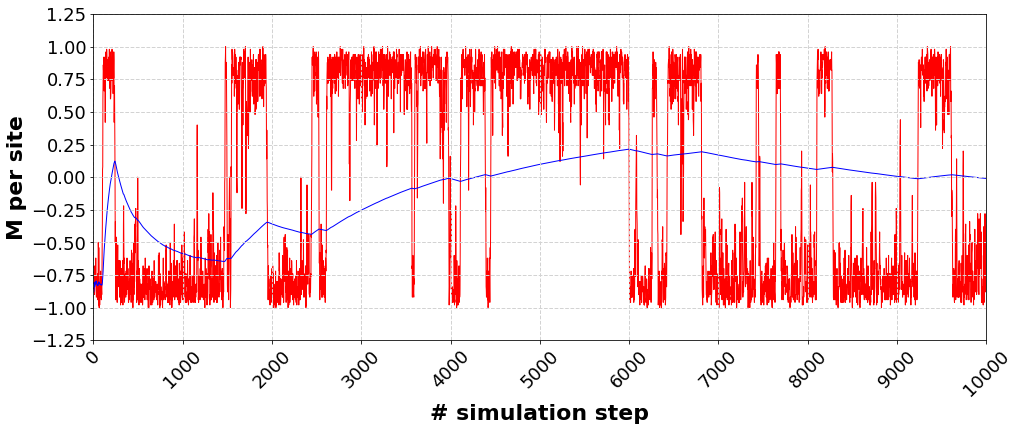

In [7]:
## The magnetisation
plt.figure(figsize=(16,6))

plt.plot(x, propM, color="red"   ,linewidth=1, zorder=-1, alpha=1)
plt.plot(x, avgM,  color="blue"  ,linewidth=1, zorder=-1, alpha=1)
plt.xscale("linear")
plt.yscale("linear")
#maxE=abs(2*J)+abs(B)
maxM=1.25
plt.axis([0,mcsmax,-maxM,maxM])
Xlst=np.linspace(0,mcsmax,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-5,5,11))*(maxM*0.2)
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# simulation step",fontsize=22,fontweight="bold")
plt.ylabel("M per site",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.show()

## 3. Critical temperature ##
### 3.1. Simulation ###

In [8]:
J      = 1.0          # The coupling constant in energy "meV" (1k_BT = 26meV@RT)
Bfield = 0.0          # The magnetic field in Tesla
muB    = 5.788381e-2  # Bohrmagneton in meV/Tesla
Bf     = Bfield*muB   # Practical magnetic field factor in meV
nT     = 200           # Number of temperature steps
scale  = 0.25          # Scale factor for the temperatures
T      = np.arange(start=1,stop=1+nT, step=1)*scale # Temperature-list in Kelvin
kBT    = T*8.617333e-2# k_B in meV/K
latdim = 10           # Lateral lattice dimension
N      = latdim**2    # Total number of lattice sites in a 2D lattice

mcsmax  = 1000   # Number of lattice sweeps to perform
Ninit   = 2      # Number of sweeps used as initialisation of the system
Nsample = 1      # System properties are collected every # systems-sweeps
mcNames = list() # List containing the names of the different "models"

## Lists collecting specific properties per temperature 
TavgE = np.zeros((nT,3)) # for up to 3 experimental runs in parallel
TavgM = np.zeros((nT,3))
TstdE = np.zeros((nT,3)) # for up to 3 experimental runs in parallel
TstdM = np.zeros((nT,3)) # the standard deviations in case of ensembles


## look-up tables
kp,km=get_PBC(latdim)

## A. Monte Carlo run...the book version
mod = 0 # MC-model index
bar = tqdm(total=nT)
mcNames.append("Ordered sweep (book)")
for nrT in range(nT):
    ## setup the temperature dependent transion probabilities
    w = get_transProb(latdim,J,Bf,kBT[nrT])
    ## initialisation of the grid
    grid = init_sampleFM(latdim)
    ## Properties we want to track
    propE = list() # The total energy
    propM = list() # The total magnetisation
    
    cnt=0
    for mcs in range(mcsmax):
        do_mcs_step_BookSweep(grid,latdim,kp,km,w)# do a single update-round
        if mcs>Ninit:
            cnt+=1
            if cnt>=Nsample:
                propE.append(calc_TotE(grid,latdim,Bf,J,kp,km))
                propM.append(calc_TotM(grid))
                cntp+=1
                cnt=0
    TavgE[nrT,mod]=np.mean(propE) 
    TavgM[nrT,mod]=abs(np.mean(propM))
    ## draw a progressbar...as this will take a while
    bar.update()
bar.close()

## B. Monte Carlo run...the random sweep over equivalent lattice
mod = 1    
bar = tqdm(total=nT)
mcNames.append("Random sweep")
for nrT in range(nT):
    ## setup the temperature dependent transion probabilities
    w=get_transProb(latdim,J,Bf,kBT[nrT])
    ## initialisation of the grid
    grid=init_sampleRand(latdim)
    ## Properties we want to track
    propE = list() # The total energy
    propM = list() # The total magnetisation
    
    cnt=0
    for mcs in range(mcsmax):
        do_mcs_step_RandSweep(grid,latdim,kp,km,w)# do a different model
        if mcs>Ninit:
            cnt+=1
            if cnt>=Nsample:
                propE.append(calc_TotE(grid,latdim,Bf,J,kp,km))
                propM.append(calc_TotM(grid))
                cntp+=1
                cnt=0
    TavgE[nrT,mod]=np.mean(propE) 
    TavgM[nrT,mod]=abs(np.mean(propM))
    ## draw a progressbar...as this will take a while
    bar.update()
bar.close()

## C. Monte Carlo run...the random sweep over equivalent lattice...in an ensemble approach
Nens = 100 # ensembles of 100 runs
mod = 2    
bar = tqdm(total=nT)
mcNames.append("Random sweep Ensemble")
for nrT in range(nT):
    ## setup the temperature dependent transion probabilities
    w=get_transProb(latdim,J,Bf,kBT[nrT])
    ensE=np.zeros(Nens)
    ensM=np.zeros(Nens)
    for ens in range(Nens):
        ## initialisation of the grid
        grid=init_sampleRand(latdim)
        ## Properties we want to track
        propE = list() # The total energy
        propM = list() # The total magnetisation
    
        cnt=0
        for mcs in range(mcsmax):
            do_mcs_step_RandSweep(grid,latdim,kp,km,w)# do a different model
            if mcs>Ninit:
                cnt+=1
                if cnt>=Nsample:
                    propE.append(calc_TotE(grid,latdim,Bf,J,kp,km))
                    propM.append(calc_TotM(grid))
                    cntp+=1
                    cnt=0
        ensE[ens]=np.mean(propE)
        ensM[ens]=abs(np.mean(propM))
    
    TavgE[nrT,mod]=np.mean(ensE) 
    TavgM[nrT,mod]=np.mean(ensM)
    TstdE[nrT,mod]=np.std(ensE)
    TstdM[nrT,mod]=np.std(ensM)
    ## draw a progressbar...as this will take a while
    bar.update()
bar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [4:26:28<00:00, 81.52s/it]


### 3.2. Plot the results ###

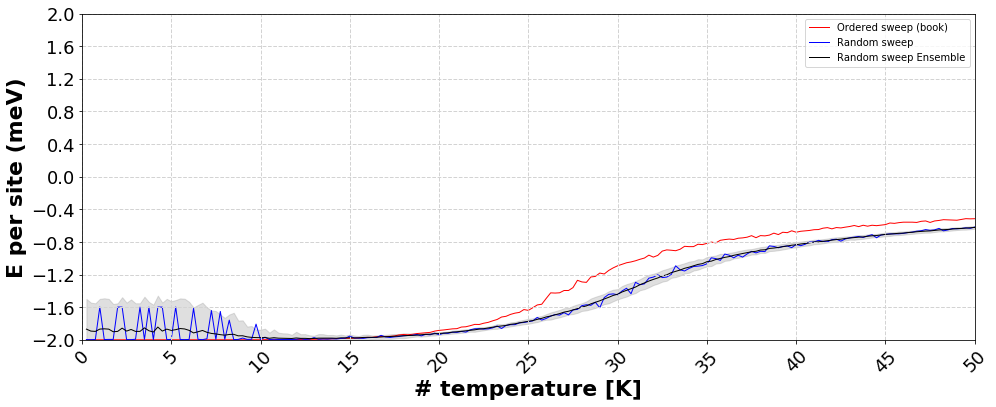

In [9]:
## The energy
plt.figure(figsize=(16,6))
plt.plot(T, TavgE[:,0], color="red"   ,linewidth=1, zorder=1, alpha=1, label=mcNames[0])
plt.plot(T, TavgE[:,1], color="blue"   ,linewidth=1, zorder=1, alpha=1, label=mcNames[1])
plt.plot(T, TavgE[:,2], color="black"   ,linewidth=1, zorder=1, alpha=1, label=mcNames[2])
plt.fill_between(T, TavgE[:,2]-2*TstdE[:,2], TavgE[:,2]+2*TstdE[:,2], color="grey",
                  zorder=-1, alpha=0.25)

plt.xscale("linear")
plt.yscale("linear")
maxE=max([abs(np.amin(TavgE[:,])),np.amax(TavgE)])
plt.axis([0,nT*scale,np.amin(TavgE),np.amax(TavgE)])
Xlst=np.linspace(0,nT*scale,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-5,5,11))*(maxE*0.2)
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# temperature [K]",fontsize=22,fontweight="bold")
plt.ylabel("E per site (meV)",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.legend()
plt.show()

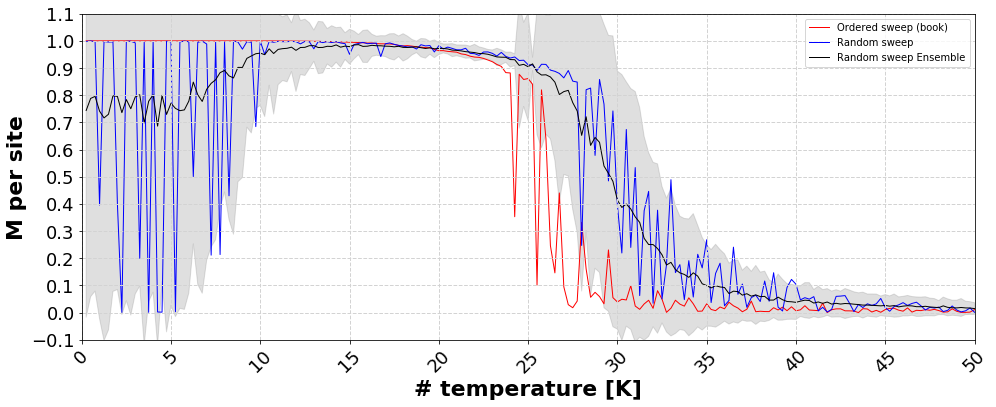

In [10]:
## The magnetisation
plt.figure(figsize=(16,6))
plt.plot(T, TavgM[:,0], color="red"   ,linewidth=1, zorder=-1, alpha=1, label=mcNames[0])
plt.plot(T, TavgM[:,1], color="blue"   ,linewidth=1, zorder=-1, alpha=1, label=mcNames[1])
plt.plot(T, TavgM[:,2], color="black"   ,linewidth=1, zorder=1, alpha=1, label=mcNames[2])
plt.fill_between(T, TavgM[:,2]-2*TstdM[:,2], TavgM[:,2]+2*TstdM[:,2], color="grey",
                  zorder=-1, alpha=0.25)


plt.xscale("linear")
plt.yscale("linear")
maxM=1.25
plt.axis([0,nT*scale,-0.1,np.amax(TavgM)*1.1])
Xlst=np.linspace(0,nT*scale,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-1,11,13))*0.1
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# temperature [K]",fontsize=22,fontweight="bold")
plt.ylabel("M per site",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.legend()
plt.show()